## PFT survival
This code shows as simple way to:
- Reads in h1 files using xarray
- Find max monthly LAIs for each PFT and calculates 'survival'
- Uses facetgrid to plot max LAI that highlights dead grids
  
uses sparse grid example from ESDS
https://ncar.github.io/esds/posts/2022/sparse-PFT-gridding/

#### Import Libraries

In [1]:
import re
import os
import time
import datetime
import calendar
import tqdm
import cftime
import dask

#from ctsm_py import utils
from netCDF4 import num2date
from glob import glob
from os.path import join

import numpy as np
import pandas as pd
import xarray as xr

# some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

# some nice plotting settings
#xr.set_options(cmap_sequential=mpl.cm.YlGn, keep_attrs=True)
plt.rcParams["figure.dpi"] = 120
cbar_kwargs = {"orientation": "horizontal", "shrink": 0.8, "aspect": 30}


def setup_axes():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    return ax

In [2]:
## This is in utils, but will load it here too
def time_set_mid(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with midpoints of
    ds[time_name].attrs['bounds'], if bounds attribute exists.
    Except for time_name, the returned Dataset is a copy of ds2.
    The copy is deep or not depending on the argument deep.
    """

    ds_out = ds.copy(deep)

    if "bounds" not in ds[time_name].attrs:
        return ds_out

    tb_name = ds[time_name].attrs["bounds"]
    tb = ds[tb_name]
    bounds_dim = next(dim for dim in tb.dims if dim != time_name)

    # Use da = da.copy(data=...), in order to preserve attributes and encoding.

    # If tb is an array of datetime objects then encode time before averaging.
    # Do this because computing the mean on datetime objects with xarray fails
    # if the time span is 293 or more years.
    #     https://github.com/klindsay28/CESM2_coup_carb_cycle_JAMES/issues/7
    if tb.dtype == np.dtype("O"):
        units = "days since 0001-01-01"
        calendar = "noleap"
        tb_vals = cftime.date2num(ds[tb_name].values, units=units, calendar=calendar)
        tb_mid_decode = cftime.num2date(
            tb_vals.mean(axis=1), units=units, calendar=calendar
        )
        ds_out[time_name] = ds[time_name].copy(data=tb_mid_decode)
    else:
        ds_out[time_name] = ds[time_name].copy(data=tb.mean(bounds_dim))

    return ds_out

----
### Read in h1 data to look at PFT survival

Single variable time series can be made with the following:

`ncrcat -v TLAI,pfts1d_ixy,pfts1d_jxy,pfts1d_itype_veg,lat,lon ctsm53017_f19_BNF_hist.clm2.h1.192* /glade/derecho/scratch/wwieder/ctsm53017_f19_BNF_hist.clm2.h1.TLAI.1920s.nc`

In [3]:
cases = ['ctsm530_f19_PPE_hist', 'ctsm530_f19_nfix_param2_hist']
cases_short = ['CLM53_PPE', 'NFIX + Param*']
c = 1          # select the case to plot
var = 'TLAI'
file = '.clm2.h1.'+var+'.185*.nc'
path = '/glade/derecho/scratch/oleson/timeseries/'+cases[c]+'/lnd/proc/tseries/month_1/'
#path1 = '/glade/derecho/scratch/wwieder/'+cases[c]+'/run/'
fin = []
fin.extend(sorted(glob(join(path+cases[c]+file))))


### Hard coded for my hacked job...
c = 0          # select the case to plot
cases = ['ctsm53n04ctsm52028_f09_hist', 'ctsm53019_f09_BNF_hist']
cases_short = ['CLM53_PPE', 'CLM53_NEW']
fin = ['/glade/derecho/scratch/wwieder/ctsm53n04ctsm52028_f09_hist.clm2.h1.TLAI.1860s.nc',
       '/glade/derecho/scratch/wwieder/ctsm53019_f09_BNF_hist.clm2.h1.TLAI.1860s.nc']
# Open datasets, loading into memory here to avoid using dask
ds_in = time_set_mid(xr.open_mfdataset(fin[c], decode_times=True), 'time')
ds_in

<xarray.Dataset>
Dimensions:           (time: 120, hist_interval: 2, lon: 288, lat: 192,
                       pft: 911714)
Coordinates:
  * time              (time) object 1860-01-16 12:00:00 ... 1869-12-16 12:00:00
  * lon               (lon) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat               (lat) float32 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval, pft
Data variables:
    time_bounds       (time, hist_interval) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    pfts1d_ixy        (pft) float64 dask.array<chunksize=(911714,), meta=np.ndarray>
    pfts1d_jxy        (pft) float64 dask.array<chunksize=(911714,), meta=np.ndarray>
    pfts1d_itype_veg  (pft) float64 dask.array<chunksize=(911714,), meta=np.ndarray>
    TLAI              (time, pft) float32 dask.array<chunksize=(120, 911714), meta=np.ndarray>
Attributes: (12/102)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Wed Jan 29 14:54:26 2025: ncrcat -v...
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./ctsm53n04ctsm52028_f09_hist.clm2....
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...
    NCO:                                  netCDF Operators version 5.2.4 (Hom...

In [4]:
pft_constants = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/cseg/inputdata/lnd/clm2/paramdata/ctsm60_params.c241017.nc')
pftnames = pft_constants.pftname

Our goal here is to expand this 2D GPP dataarray to a 4D sparse array `(time, type, lat, lon)`.

This way no extra memory is used to represent NaNs over the ocean.

We get to work with a substantially simpler representation of the dataset.

We develop the following two functions: to_sparse and convert_pft_variables_to_sparse

In [5]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

#### Now convert to gridded output

In [6]:
sparse_data = convert_pft_variables_to_sparse(ds_in.isel(time=slice(0,120)), pftnames).load()
sparse_data

Format,coo
Data Type,float64
Shape,"(79, 192, 288)"
nnz,819507
Density,0.18759957915787623
Read-only,True
Size,25.0M
Storage ratio,0.75
Format,coo
Data Type,float64
Shape,"(79, 192, 288)"


#### Quick sanity check of results

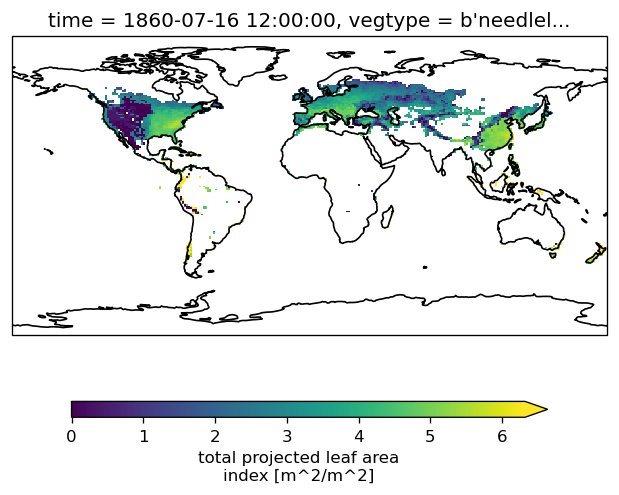

In [7]:
ax = setup_axes()
sparse_data['TLAI'].isel(vegtype=1, time=6).plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)


### Make facet grid with all pfts


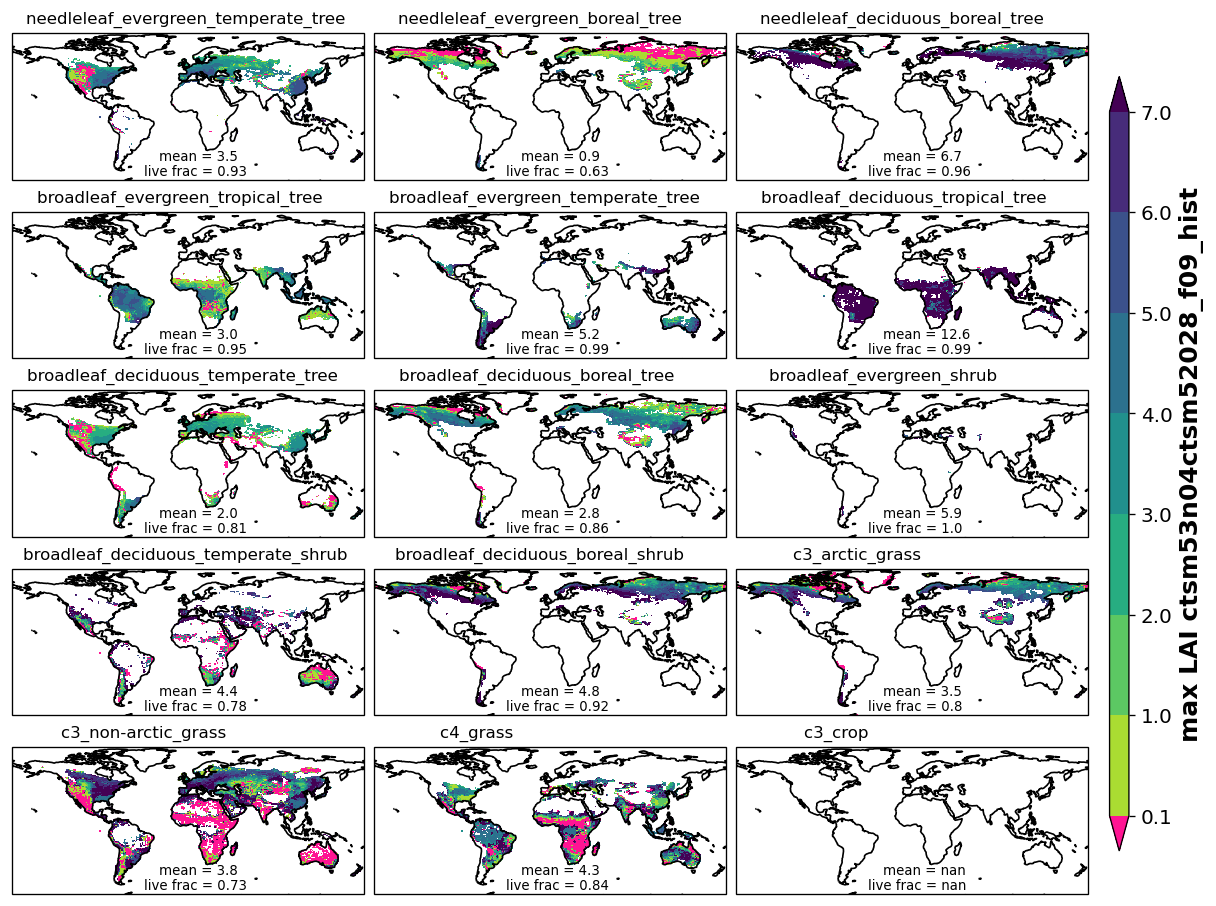

In [8]:
cmap = plt.cm.viridis_r
cmap.set_under(color='deeppink')
levels = [0.1, 1, 2, 3, 4, 5, 6,7]

fg = sparse_data.TLAI.isel(vegtype=slice(1, 16)).sel(lat=slice(-65,85)).max('time').plot(
    x = "lon", y="lat", col = "vegtype", 
    col_wrap=3, cmap = cmap, levels=levels,
    cbar_kwargs={#"orientation": "vertical", "shrink": 0.8, 
                 #"aspect": 40, "pad": 0.01
    },
    transform = ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.PlateCarree()},
    add_colorbar=False
)

# Make some custom titles and info for each plot
titles,mean,alive = [],[],[]
for i in range(1,16):
    titles.append(str(sparse_data.vegtype[i].data)[2:38])
    mean.append('mean = '+str(np.round(sparse_data.TLAI.isel(vegtype=i).max('time').mean().values,1)))
    dead = (sparse_data.TLAI.isel(vegtype=i).max('time')<0.1).sum()
    live = (sparse_data.TLAI.isel(vegtype=i).max('time')>0.1).sum()
    livefrac = str(np.round((live/(live+dead)).values,2))
    alive.append('live frac = '+livefrac)

for ax, title in zip(fg.axs.flat, titles):
    ax.set_title(title,fontsize=10)#,loc='left',backgroundcolor = 'white')

for ax, mean in zip(fg.axs.flat, mean):
    ax.text(-30,-45,mean,fontsize=8)
    
for ax, alive in zip(fg.axs.flat, alive):
    ax.text(-45,-60,alive,fontsize=8)

for ax in fg.axs.flat:  # loop through the map axes
    ax.coastlines()

#fg.fig.title('test title')

fg.fig.set_layout_engine("compressed")
fg.add_colorbar(pad=0.02, shrink=0.9, aspect=40)
fg.cbar.ax.tick_params(labelsize=12)
fg.cbar.set_label(label=("max LAI "+cases[c]), size=15, weight='bold')
#plt.suptitle(cases[c],ha='center',va='bottom')
#plt.subplots_adjust(top=0.95)
plt.show() ;

-----